<h1 align="center">Tidying up LFP data from matlab cell array -  Control</h1> 

In [155]:
!date

Wed Mar  9 16:37:34 PST 2022


___

## Manually define the following parameters:

#### Define matlab files to analyze

In [156]:
files = "raw_data/control*"

#### Define experiment condition (for figure titles)

In [157]:
condition = "Control"

#### Define bird IDs

In [158]:
bird1 = "Or295"
bird2 = "PK31"

#### Define maximum frequency. Power values for frequencies above freq_max will be discarded

In [159]:
freq_max = 500

#### Define start indeces of freq. ranges to sum, e.g. ranges 1-10, 11-100, and 101-end (manual log scale) power values for this hour
For the log scale, define the last slice to start at position 95 because frequencies 58-62 Hz will be removed due to American outlet noise and then frequency 101 Hz will be located at index 95.

In [160]:
freq_range = [0, 11, 96]

freq_range_label = ["1-10", "11-100", f"101-{freq_max}"]

#### Define number of morning hours

In [161]:
m_hours = 5

#### Define channels to be excluded because they are likely outside HVC

In [162]:
outside_HVC = [3, 7, 11, 15, 1, 5, 9, 13]

#### Define whether to keep only one channel or average across all channels
Excluding channels with broken electrodes and channels outside HVC.

In [163]:
# Define as "multi" or "single"
channels_used = "multi"

#### Make sure to define the days-to-dpi mapping and channels with broken electrodes to be removed below!

___

## Import packages

In [164]:
%load_ext blackcellmagic
%config InlineBackend.figure_format='retina'

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [165]:
import glob
import scipy.io as sio

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import cm

___

## Load data (cellarrays generated from raw data in matlab)

In [166]:
# Get all files to analyze
glob.glob(files)

['raw_data/control_09_25_09_28_evening_bulk_power.mat',
 'raw_data/control_09_29_09_30_evening_bulk_power.mat',
 'raw_data/control_11_08_11_21_evening_bulk_power.mat',
 'raw_data/control_09_02_00_00_evening_bulk_power.mat',
 'raw_data/control_10_20_11_05_morning_bulk_power.mat',
 'raw_data/control_09_11_09_13_evening_bulk_power.mat',
 'raw_data/control_11_23_00_00_morning_bulk_power.mat',
 'raw_data/control_09_14_09_23_evening_bulk_power.mat',
 'raw_data/control_12_14_12_16_evening_bulk_power.mat',
 'raw_data/control_10_02_10_18_morning_bulk_power.mat',
 'raw_data/control_11_23_00_00_evening_bulk_power.mat',
 'raw_data/control_12_14_12_16_morning_bulk_power.mat',
 'raw_data/control_10_02_10_18_evening_bulk_power.mat',
 'raw_data/control_09_14_09_23_morning_bulk_power.mat',
 'raw_data/control_09_02_00_00_morning_bulk_power.mat',
 'raw_data/control_10_20_11_05_evening_bulk_power.mat',
 'raw_data/control_11_08_11_21_morning_bulk_power.mat',
 'raw_data/control_09_11_09_13_morning_bulk_powe

Raw power values are stored in tab 'evening_rec_chan_cell' and 'morning_rec_chan_cell' inside each mat file.

### !!! Files with 00_00 date do not include successive days and need custom day adjustment:
Date legend:  
09_02_00_00: 09/02, 09/03, 09/04, 09/05, 09/06, 09/07, 09/08, 09/10 - ONLY CONTAINS DATA FROM Or295  
11_23_00_00: 11/23, 11/24, 11/25, 11/26, 11/27, 11/28, 11/29, 11/30, 12/01, 12/05, 12/07, 12/08, 12/09

## Create a tidy data frame containing raw power values for morning and evening data
Note: The second, fourth and fifth array of each mat_contents file are empty and have no meaning. They are a side effect of the cellarray structure in matlab.

In [167]:
%%time
# Create empty lists to record data from all files
dates_all = []
recs_all = []
channels_all = []
hours_all = []
power_all = []
daytimes_all = []
freqs_all = []

# Define frequencies to be kept in final tidy dataframe (excluding freqs 58-62 Hz due to American outlet noise)
temp = np.arange(0,freq_max) + 1
freq_range_clean = np.concatenate([temp[:57], temp[62:freq_max]])

for file in glob.glob(files):
    # Add some space between print outs
    print(" ")
    
    # Load matlab file
    mat_contents = sio.loadmat(file)
    sub_folder = list(mat_contents.keys())[-1]
    # Get the date from the file name
    d = "-".join(["/".join(file.split("/")[-1].split("_")[1:3]), "/".join(file.split("/")[-1].split("_")[3:5])])
    # Get the daytime (morning or evening) from the file name
    daytime = file.split("/")[-1].split("_")[5]
    
    # Find number of days recorded
    n_recs = len(mat_contents[sub_folder])
    
    # Print some info about the data
    print("Date: ", d)
    print("Daytime: ", daytime)
    print("Filename: ", file)
    print("Subfolder: ", sub_folder)
    print("Days recorded: ", n_recs)
    
    # Create empty lists to record data from this day
    dates = []
    recs = []
    channels = []
    hours = []
    power = []
    daytimes = []
    freqs = []

    for rec in range(n_recs):
        # Find number of channels in this recording
        n_channels = len(mat_contents[sub_folder][rec][0])
        print(f"Channels in day {rec}: ", n_channels)
        
        # Only include days that were actually recorded and hence have > 1 channels
        if n_channels > 1:
            for channel in range(n_channels):
                # Find number of hours in this channel
                n_hours = len(mat_contents[sub_folder][rec][0][channel][0])  
                
                # Print number of hours if it is not 5 (expected value)
                if n_hours != 5:
                        print(f"Number of hours in day {rec}, channel {channel}: ", n_hours)

                for hour in range(n_hours):
                    # Print number of power values if it is not 800 (expected value)
                    if len(mat_contents[sub_folder][rec][0][channel][0][hour][0][0]) != 800:
                        print(f"Number of power values in day {rec}, channel {channel}, hour {hour}: ", len(mat_contents[sub_folder][rec][0][channel][0][hour][0][0]))
                    
                    # Get power values for frequencies 1 - freq_max, removing frequencies 58 - 62 (American outlet noise)
                    powers = np.concatenate([mat_contents[sub_folder][rec][0][channel][0][hour][0][0][:57], mat_contents[sub_folder][rec][0][channel][0][hour][0][0][62:freq_max]]) 
                    
                    ## Append the power values with their corresponding information to lists
                    power.append(powers)
                    dates.append([d,] * len(powers))
                    recs.append([[rec],] * len(powers))
                    # Add 1 to channel to correct for Python 0 indexing
                    channels.append([channel+1,] * len(powers))
                    hours.append([hour,] * len(powers))
                    daytimes.append([daytime,] * len(powers))
                    freqs.append(freq_range_clean)

    # Concatenate the lists                
    power = np.concatenate(power)
    dates = np.concatenate(dates)
    recs = np.concatenate(recs)
    channels = np.concatenate(channels)
    hours = np.concatenate(hours)
    daytimes = np.concatenate(daytimes)
    freqs = np.concatenate(freqs)  
    
    # Append the information from this day to the lists containing info from all files 
    dates_all.append(dates)
    recs_all.append(recs)
    channels_all.append(channels)
    hours_all.append(hours)
    power_all.append(power)
    daytimes_all.append(daytimes)
    freqs_all.append(freqs)

 
Date:  09/25-09/28
Daytime:  evening
Filename:  raw_data/control_09_25_09_28_evening_bulk_power.mat
Subfolder:  evening_rec_chan_cell
Days recorded:  4
Channels in day 0:  32
Channels in day 1:  32
Channels in day 2:  32
Channels in day 3:  32
 
Date:  09/29-09/30
Daytime:  evening
Filename:  raw_data/control_09_29_09_30_evening_bulk_power.mat
Subfolder:  evening_rec_chan_cell
Days recorded:  2
Channels in day 0:  38
Number of hours in day 0, channel 32:  0
Number of hours in day 0, channel 33:  0
Number of hours in day 0, channel 34:  0
Number of hours in day 0, channel 35:  0
Number of hours in day 0, channel 36:  0
Number of hours in day 0, channel 37:  0
Channels in day 1:  38
Number of hours in day 1, channel 32:  0
Number of hours in day 1, channel 33:  0
Number of hours in day 1, channel 34:  0
Number of hours in day 1, channel 35:  0
Number of hours in day 1, channel 36:  0
Number of hours in day 1, channel 37:  0
 
Date:  11/08-11/21
Daytime:  evening
Filename:  raw_data/con

!!! Note: File from 09/29-09/30 contained accelerometer data in channels 33-38 (indexed at 32-37). Those arrays are now empty and are not included in the data frame below.

Create data frame from lists containing info from all files:

In [168]:
%%time
power_all = np.concatenate(power_all)
dates_all = np.concatenate(dates_all)
recs_all = np.concatenate(recs_all)
channels_all = np.concatenate(channels_all)
hours_all = np.concatenate(hours_all)
daytimes_all = np.concatenate(daytimes_all)
freqs_all = np.concatenate(freqs_all)

# Create data frame
df_orig = pd.DataFrame()
df_orig["date"] = dates_all
df_orig["daytime"] = daytimes_all
df_orig["day"] = recs_all
df_orig["channel"] = channels_all
df_orig["hour"] = hours_all
df_orig["freq"] = freqs_all
df_orig["power"] = power_all

CPU times: user 5.36 s, sys: 7.6 s, total: 13 s
Wall time: 19.2 s


In [169]:
# Add experiment condition to data frame
df_orig["condition"] = condition

df_orig

,date,daytime,day,channel,hour,freq,power,condition
0,09/25-09/28,evening,0,1,0,1,41150.543985,Control
1,09/25-09/28,evening,0,1,0,2,46469.932846,Control
2,09/25-09/28,evening,0,1,0,3,37119.393080,Control
3,09/25-09/28,evening,0,1,0,4,27410.264419,Control
4,09/25-09/28,evening,0,1,0,5,20673.415778,Control
...,...,...,...,...,...,...,...,...
13305595,09/25-09/28,morning,3,32,4,496,96.834211,Control
13305596,09/25-09/28,morning,3,32,4,497,96.449566,Control
13305597,09/25-09/28,morning,3,32,4,498,97.117705,Control
13305598,09/25-09/28,morning,3,32,4,499,101.307380,Control


___

# Rename "hour" to represent morning (hours 0-4) and evening (hours 5-9)

In [170]:
df_orig["hour"].unique()

array([0, 1, 2, 3, 4])

In [171]:
# Add 5 to "hour" values where "daytime" = "evening"
df_orig.loc[df_orig["daytime"] == "evening", "hour"] += m_hours

# Show new hours
np.sort(df_orig["hour"].unique())

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## Drop the last hour of each morning and the last two hours of each evening recording in case the bird already started singing 
Morning: Drop the last hour, since the bird is more likely to sing in the first 4 hours.  
Evening: Only the first three hours are kept for each recording (these are hours 7,8,9 since the evening hours are labeled backwards).

In [172]:
for hour in [4, 5, 6]:
    df_orig = df_orig[df_orig.hour != hour]

# Show new hours
np.sort(df_orig["hour"].unique())

array([0, 1, 2, 3, 7, 8, 9])

___

# Split data from different birds

In [173]:
df_bird1 = df_orig.loc[df_orig["channel"] <= 16]
df_bird1["animal_ID"] = bird1

/var/folders/gd/8j_w3s656d1gkl7jfdnptqpc0000gq/T/ipykernel_11355/1710075169.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bird1["animal_ID"] = bird1


In [174]:
df_bird2 = df_orig.loc[df_orig["channel"] > 16]
df_bird2["animal_ID"] = bird2
# Substract 16 from channels of bird 2, since its channels were saved as 16-31 instead of 0-15
df_bird2["channel"] -= 16

/var/folders/gd/8j_w3s656d1gkl7jfdnptqpc0000gq/T/ipykernel_11355/2512377287.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bird2["animal_ID"] = bird2
/var/folders/gd/8j_w3s656d1gkl7jfdnptqpc0000gq/T/ipykernel_11355/2512377287.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_bird2["channel"] -= 16


In [175]:
df_bird2.head()

,date,daytime,day,channel,hour,freq,power,condition,animal_ID
40590,09/25-09/28,evening,0,1,7,1,4820.284744,Control,PK31
40591,09/25-09/28,evening,0,1,7,2,5337.561514,Control,PK31
40592,09/25-09/28,evening,0,1,7,3,4611.990490,Control,PK31
40593,09/25-09/28,evening,0,1,7,4,3813.795944,Control,PK31
40594,09/25-09/28,evening,0,1,7,5,2952.470486,Control,PK31


___

# Fix the "day" column so days correctly reflect dpi (day post injection) for each bird

### !!! Files with 00_00 date do not include successive days and need custom day adjustment:
Date legend:  
09_02_00_00: 09/02, 09/03, 09/04, 09/05, 09/06, 09/07, 09/08, 09/10 - ONLY CONTAINS DATA FROM Or295  
11_23_00_00: 11/23, 11/24, 11/25, 11/26, 11/27, 11/28, 11/29, 11/30, 12/01, 12/05, 12/07, 12/08, 12/09

In [176]:
# Show unique days before dpi correction
df_bird1["day"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [177]:
# Show dates of files
np.sort(df_bird1["date"].unique())

array(['09/02-00/00', '09/11-09/13', '09/14-09/23', '09/25-09/28',
       '09/29-09/30', '10/02-10/18', '10/20-11/05', '11/08-11/21',
       '11/23-00/00', '12/14-12/16'], dtype=object)

In [178]:
# Set dpi for files with non-consecutive days based on date-day mapping (see csv file)
# 09/10
df_bird1.loc[((df_bird1["date"] == "09/02-00/00") & (df_bird1["day"] == 7)), "day"] = 9
# 09/08
df_bird1.loc[((df_bird1["date"] == "09/02-00/00") & (df_bird1["day"] == 6)), "day"] = 7
# 09/07
df_bird1.loc[((df_bird1["date"] == "09/02-00/00") & (df_bird1["day"] == 5)), "day"] = 6
# 09/06
df_bird1.loc[((df_bird1["date"] == "09/02-00/00") & (df_bird1["day"] == 4)), "day"] = 5
# 09/05
df_bird1.loc[((df_bird1["date"] == "09/02-00/00") & (df_bird1["day"] == 3)), "day"] = 4
# 09/04
df_bird1.loc[((df_bird1["date"] == "09/02-00/00") & (df_bird1["day"] == 2)), "day"] = 3
# 09/03
df_bird1.loc[((df_bird1["date"] == "09/02-00/00") & (df_bird1["day"] == 1)), "day"] = 2
# 09/02
df_bird1.loc[((df_bird1["date"] == "09/02-00/00") & (df_bird1["day"] == 0)), "day"] = 1

# 11/23
df_bird1.loc[((df_bird1["date"] == "11/23-00/00") & (df_bird1["day"] == 0)), "day"] = 83
# 11/24
df_bird1.loc[((df_bird1["date"] == "11/23-00/00") & (df_bird1["day"] == 1)), "day"] = 84
# 11/25
df_bird1.loc[((df_bird1["date"] == "11/23-00/00") & (df_bird1["day"] == 2)), "day"] = 85
# 11/26
df_bird1.loc[((df_bird1["date"] == "11/23-00/00") & (df_bird1["day"] == 3)), "day"] = 86
# 11/27
df_bird1.loc[((df_bird1["date"] == "11/23-00/00") & (df_bird1["day"] == 4)), "day"] = 87
# 11/28
df_bird1.loc[((df_bird1["date"] == "11/23-00/00") & (df_bird1["day"] == 5)), "day"] = 88
# 11/29
df_bird1.loc[((df_bird1["date"] == "11/23-00/00") & (df_bird1["day"] == 6)), "day"] = 89
# 11/30
df_bird1.loc[((df_bird1["date"] == "11/23-00/00") & (df_bird1["day"] == 7)), "day"] = 90
# 12/01
df_bird1.loc[((df_bird1["date"] == "11/23-00/00") & (df_bird1["day"] == 8)), "day"] = 91
# 12/05
df_bird1.loc[((df_bird1["date"] == "11/23-00/00") & (df_bird1["day"] == 9)), "day"] = 95
# 12/07
df_bird1.loc[((df_bird1["date"] == "11/23-00/00") & (df_bird1["day"] == 10)), "day"] = 97
# 12/08
df_bird1.loc[((df_bird1["date"] == "11/23-00/00") & (df_bird1["day"] == 11)), "day"] = 98
# 12/09
df_bird1.loc[((df_bird1["date"] == "11/23-00/00") & (df_bird1["day"] == 12)), "day"] = 99

# Add n days to "day" values based on date-day mapping (see csv file)
df_bird1.loc[df_bird1["date"] == "09/11-09/13", "day"] += 10
df_bird1.loc[df_bird1["date"] == "09/14-09/23", "day"] += 13
df_bird1.loc[df_bird1["date"] == "09/25-09/28", "day"] += 24
df_bird1.loc[df_bird1["date"] == "09/29-09/30", "day"] += 28
df_bird1.loc[df_bird1["date"] == "10/02-10/18", "day"] += 31
df_bird1.loc[df_bird1["date"] == "10/20-11/05", "day"] += 49
df_bird1.loc[df_bird1["date"] == "11/08-11/21", "day"] += 68
df_bird1.loc[df_bird1["date"] == "12/14-12/16", "day"] += 104

/Users/lauraluebbert/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [179]:
# Show dpis for bird 1
np.sort(df_bird1["day"].unique())

array([  1,   2,   3,   4,   5,   6,   7,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  24,  25,  26,  27,  28,
        29,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  49,  50,  51,  52,  53,  54,  55,  56,  57,
        58,  59,  60,  61,  62,  63,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  95,  97,  98,  99, 104, 105, 106])

#### Double-check that days were labeled correctly for bird 1:

In [180]:
days_collected_b1 = [1,2,3,4,5,6,7,9,10,11,12,13,14,15,16,17,18,19,20,21,22,24,25,26,27,28,29,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,68,69,70,71,72,73,74,75,76,77,78,79,80,83,84,85,86,87,88,89,90,91,95,97,98,99,104,105,106]

# Raise error if collected days is not the same as days labeled in df
difference = set(np.sort(df_bird1["day"].unique())).symmetric_difference(set(days_collected_b1))
list_difference = list(difference)
if len(list_difference)>0:
    raise ValueError(f'Newly labeled days does not equal collected days for {bird1}. The following DPIs do not match: {list_difference}')
else:
    print(f'Newly labeled days equals collected days for {bird1}.')

Newly labeled days equals collected days for Or295.


### Same for bird 2:

In [181]:
# Show unique days before dpi correction
df_bird2["day"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [182]:
# Show dates of files
np.sort(df_bird2["date"].unique())

array(['09/11-09/13', '09/14-09/23', '09/25-09/28', '09/29-09/30',
       '10/02-10/18', '10/20-11/05', '11/08-11/21', '11/23-00/00',
       '12/14-12/16'], dtype=object)

In [183]:
# 11/23
df_bird2.loc[((df_bird2["date"] == "11/23-00/00") & (df_bird2["day"] == 0)), "day"] = 74
# 11/24
df_bird2.loc[((df_bird2["date"] == "11/23-00/00") & (df_bird2["day"] == 1)), "day"] = 75
# 11/25
df_bird2.loc[((df_bird2["date"] == "11/23-00/00") & (df_bird2["day"] == 2)), "day"] = 76
# 11/26
df_bird2.loc[((df_bird2["date"] == "11/23-00/00") & (df_bird2["day"] == 3)), "day"] = 77
# 11/27
df_bird2.loc[((df_bird2["date"] == "11/23-00/00") & (df_bird2["day"] == 4)), "day"] = 78
# 11/28
df_bird2.loc[((df_bird2["date"] == "11/23-00/00") & (df_bird2["day"] == 5)), "day"] = 79
# 11/29
df_bird2.loc[((df_bird2["date"] == "11/23-00/00") & (df_bird2["day"] == 6)), "day"] = 80
# 11/30
df_bird2.loc[((df_bird2["date"] == "11/23-00/00") & (df_bird2["day"] == 7)), "day"] = 81
# 12/01
df_bird2.loc[((df_bird2["date"] == "11/23-00/00") & (df_bird2["day"] == 8)), "day"] = 82
# 12/05
df_bird2.loc[((df_bird2["date"] == "11/23-00/00") & (df_bird2["day"] == 9)), "day"] = 86
# 12/07
df_bird2.loc[((df_bird2["date"] == "11/23-00/00") & (df_bird2["day"] == 10)), "day"] = 88
# 12/08
df_bird2.loc[((df_bird2["date"] == "11/23-00/00") & (df_bird2["day"] == 11)), "day"] = 89
# 12/09
df_bird2.loc[((df_bird2["date"] == "11/23-00/00") & (df_bird2["day"] == 12)), "day"] = 90

# Add n days to "day" values based on date-day mapping (see csv file)
df_bird2.loc[df_bird2["date"] == "09/11-09/13", "day"] += 1
df_bird2.loc[df_bird2["date"] == "09/14-09/23", "day"] += 4
df_bird2.loc[df_bird2["date"] == "09/25-09/28", "day"] += 15
df_bird2.loc[df_bird2["date"] == "09/29-09/30", "day"] += 19
df_bird2.loc[df_bird2["date"] == "10/02-10/18", "day"] += 22
df_bird2.loc[df_bird2["date"] == "10/20-11/05", "day"] += 40
df_bird2.loc[df_bird2["date"] == "11/08-11/21", "day"] += 59
df_bird2.loc[df_bird2["date"] == "12/14-12/16", "day"] += 95

In [184]:
# Show dpis for bird 2
np.sort(df_bird2["day"].unique())

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 15, 16, 17, 18,
       19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 59,
       60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 74, 75, 76, 77, 78,
       79, 80, 81, 82, 86, 88, 89, 90, 95, 96, 97])

#### Double-check that days were labeled correctly for bird 2:

In [185]:
days_collected_b2 = [1,2,3,4,5,6,7,8,9,10,11,12,13,15,16,17,18,19,20,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,59,60,61,62,63,64,65,66,67,68,69,70,71,74,75,76,77,78,79,80,81,82,86,88,89,90,95,96,97]

# Raise error if collected days is not the same as days labeled in df
difference = set(np.sort(df_bird2["day"].unique())).symmetric_difference(set(days_collected_b2))
list_difference = list(difference)
if len(list_difference)>0:
    raise ValueError(f'Newly labeled days does not equal collected days for {bird2}. The following DPIs do not match: {list_difference}')
else:
    print(f'Newly labeled days equals collected days for {bird2}.')

Newly labeled days equals collected days for PK31.


___

# Remove broken electrode channels

Average over all days and hours:

In [186]:
# Bird 1
df_bird1_test = df_bird1.groupby(["daytime", "channel", "freq"])[["power"]].apply(np.mean)
df_bird1_test = df_bird1_test.reset_index()

# Bird 2
df_bird2_test = df_bird2.groupby(["daytime", "channel", "freq"])[["power"]].apply(np.mean)
df_bird2_test = df_bird2_test.reset_index()
df_bird2_test

,daytime,channel,freq,power
0,evening,1,1,3963.250342
1,evening,1,2,4897.078343
2,evening,1,3,4483.693995
3,evening,1,4,3757.361712
4,evening,1,5,2958.133843
...,...,...,...,...
15835,morning,16,496,358.502909
15836,morning,16,497,358.903894
15837,morning,16,498,359.899252
15838,morning,16,499,361.832820


Plot power values over frequency for each channel:

In [187]:
def plot_channels(temp_df, bird_ID):
    """
    Plots power values over frequency on a log scale for each channel.
    Morning and evening data are plotted separately.
    """
    
    fig, axs = plt.subplots(figsize=(20, 20), ncols=4, nrows=4)
    ax_col = [0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
    ax_row = [0,1,2,3,0,1,2,3,0,1,2,3,0,1,2,3]

    for channel, (ax_col, ax_row) in zip(temp_df["channel"].unique(), zip(ax_col, ax_row)):
        temp_df2 = temp_df.loc[temp_df["channel"] == channel]
        temp_df2 = temp_df2.groupby("daytime")

        ax = axs[ax_col, ax_row]

        for name, group in temp_df2:
            ax.plot(group["freq"], group["power"], label=name, marker='o', markersize=2, linestyle='', linewidth=2)

        ax.set(**{
            "xlabel": "Freq. (Hz)",
            "ylabel": "Power",
            "title": "{} {} - Channel {}".format(condition, bird_ID, channel)
        })

        # Change axes to log scale
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_ylim(top=100000)

        # Add legend
        ax.legend()

    plt.tight_layout()        
    fig.show()

## Bird 1:

/var/folders/gd/8j_w3s656d1gkl7jfdnptqpc0000gq/T/ipykernel_11355/2944711502.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


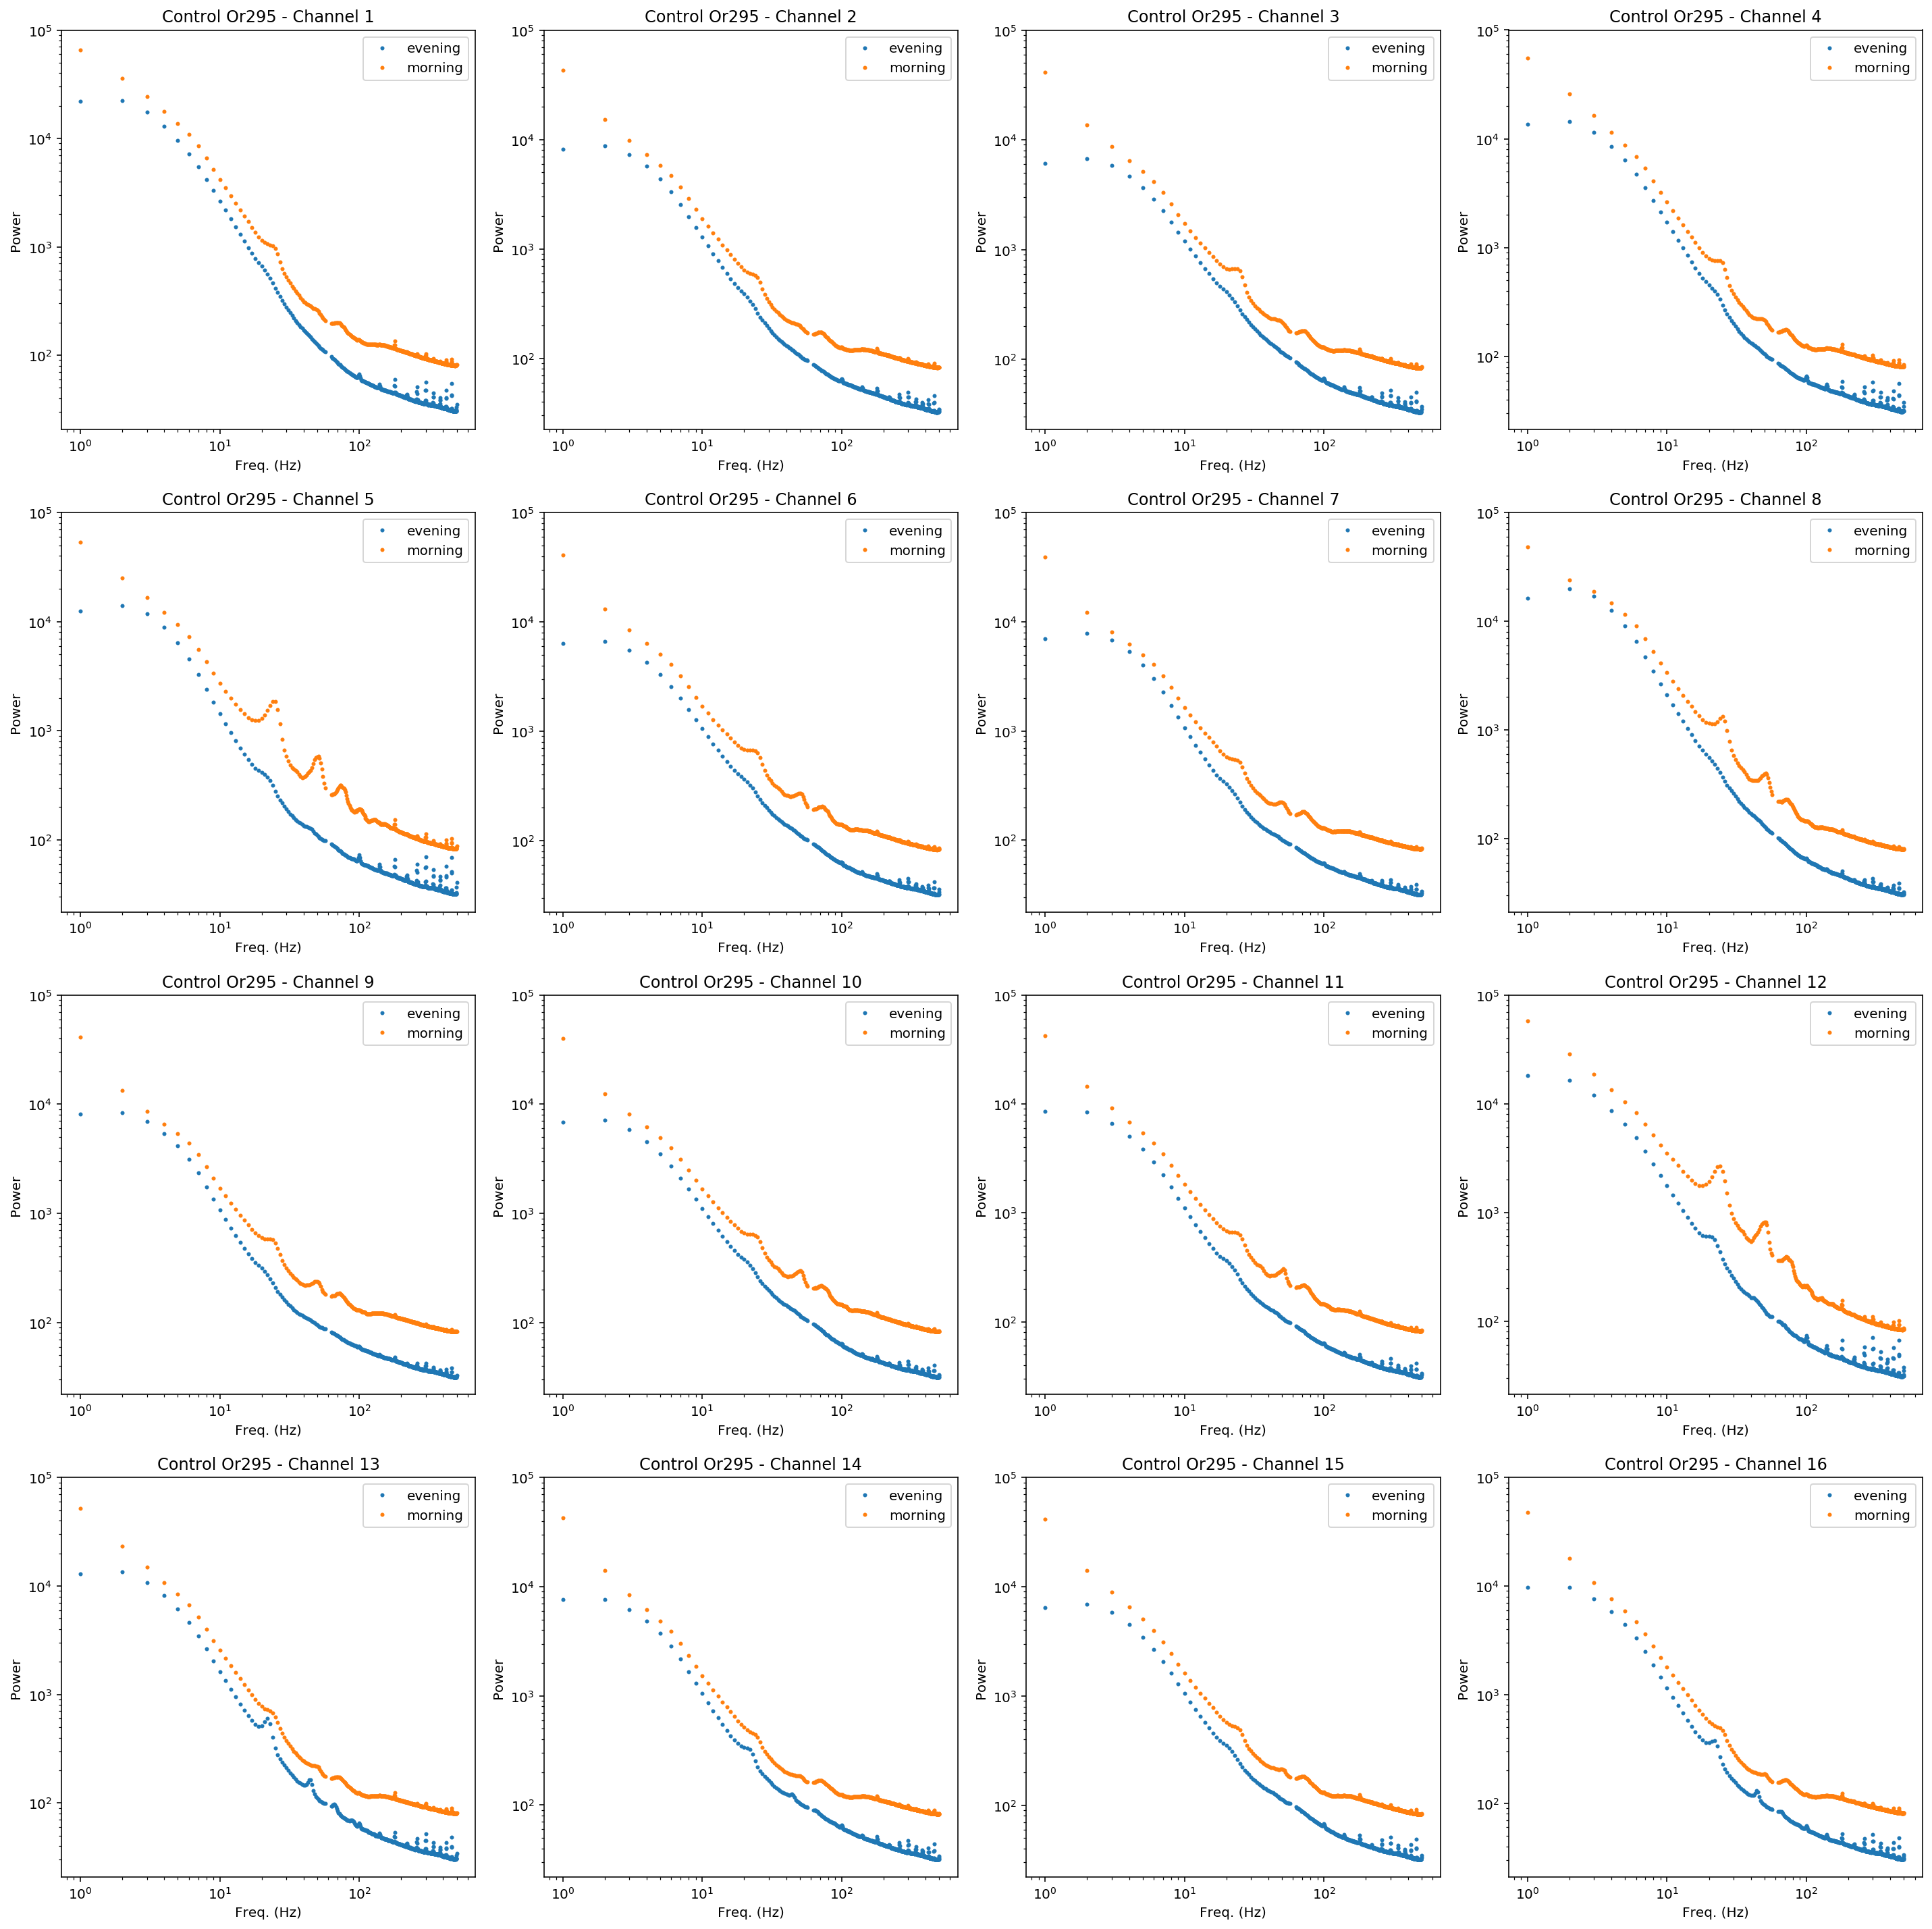

In [188]:
plot_channels(df_bird1_test, bird1)

#### !!! Manually define channels with broken electrodes to be removed from bird 1 data OR define single channel to keep

Note: Based on wavelet transform data during singing, we decided to keep channels 2,  5,  6,  7,  8,  9, 10, 11, 13, 14, 15, 16 for Or295.

In [189]:
# If averaging over multiple channels:
# Define channels with broken electrodes to remove (leave array empty if none)
bad_channels_b1 = [1, 3, 4, 12]

# If only keeping one single channel (ignored if channels_used == "multi"):
single_channel = 2

In [190]:
if channels_used == "single":
    bad_channels_b1 = df_bird1['channel'].unique()[df_bird1['channel'].unique() != single_channel]

In [191]:
for bad_channel in np.concatenate((bad_channels_b1, outside_HVC)):
    # Exclude bad channels and channels located outside HVC from test df (power values averaged across all days)
    df_bird1_test = df_bird1_test[df_bird1_test.channel != bad_channel]
    
    # Exclude bad channels and channels located outside HVC from original df
    df_bird1 = df_bird1[df_bird1.channel != bad_channel]
    
# for bad_channel in bad_channels_b1:
#     # Exclude bad channels from test df (power values averaged across all days)
#     df_bird1_test = df_bird1_test[df_bird1_test.channel != bad_channel]
    
#     # Exclude bad channels from original df
#     df_bird1 = df_bird1[df_bird1.channel != bad_channel]

In [192]:
# Show new channel list
df_bird1['channel'].unique()

array([ 2,  6,  8, 10, 14, 16])

## Same for bird 2:

/var/folders/gd/8j_w3s656d1gkl7jfdnptqpc0000gq/T/ipykernel_11355/2944711502.py:35: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


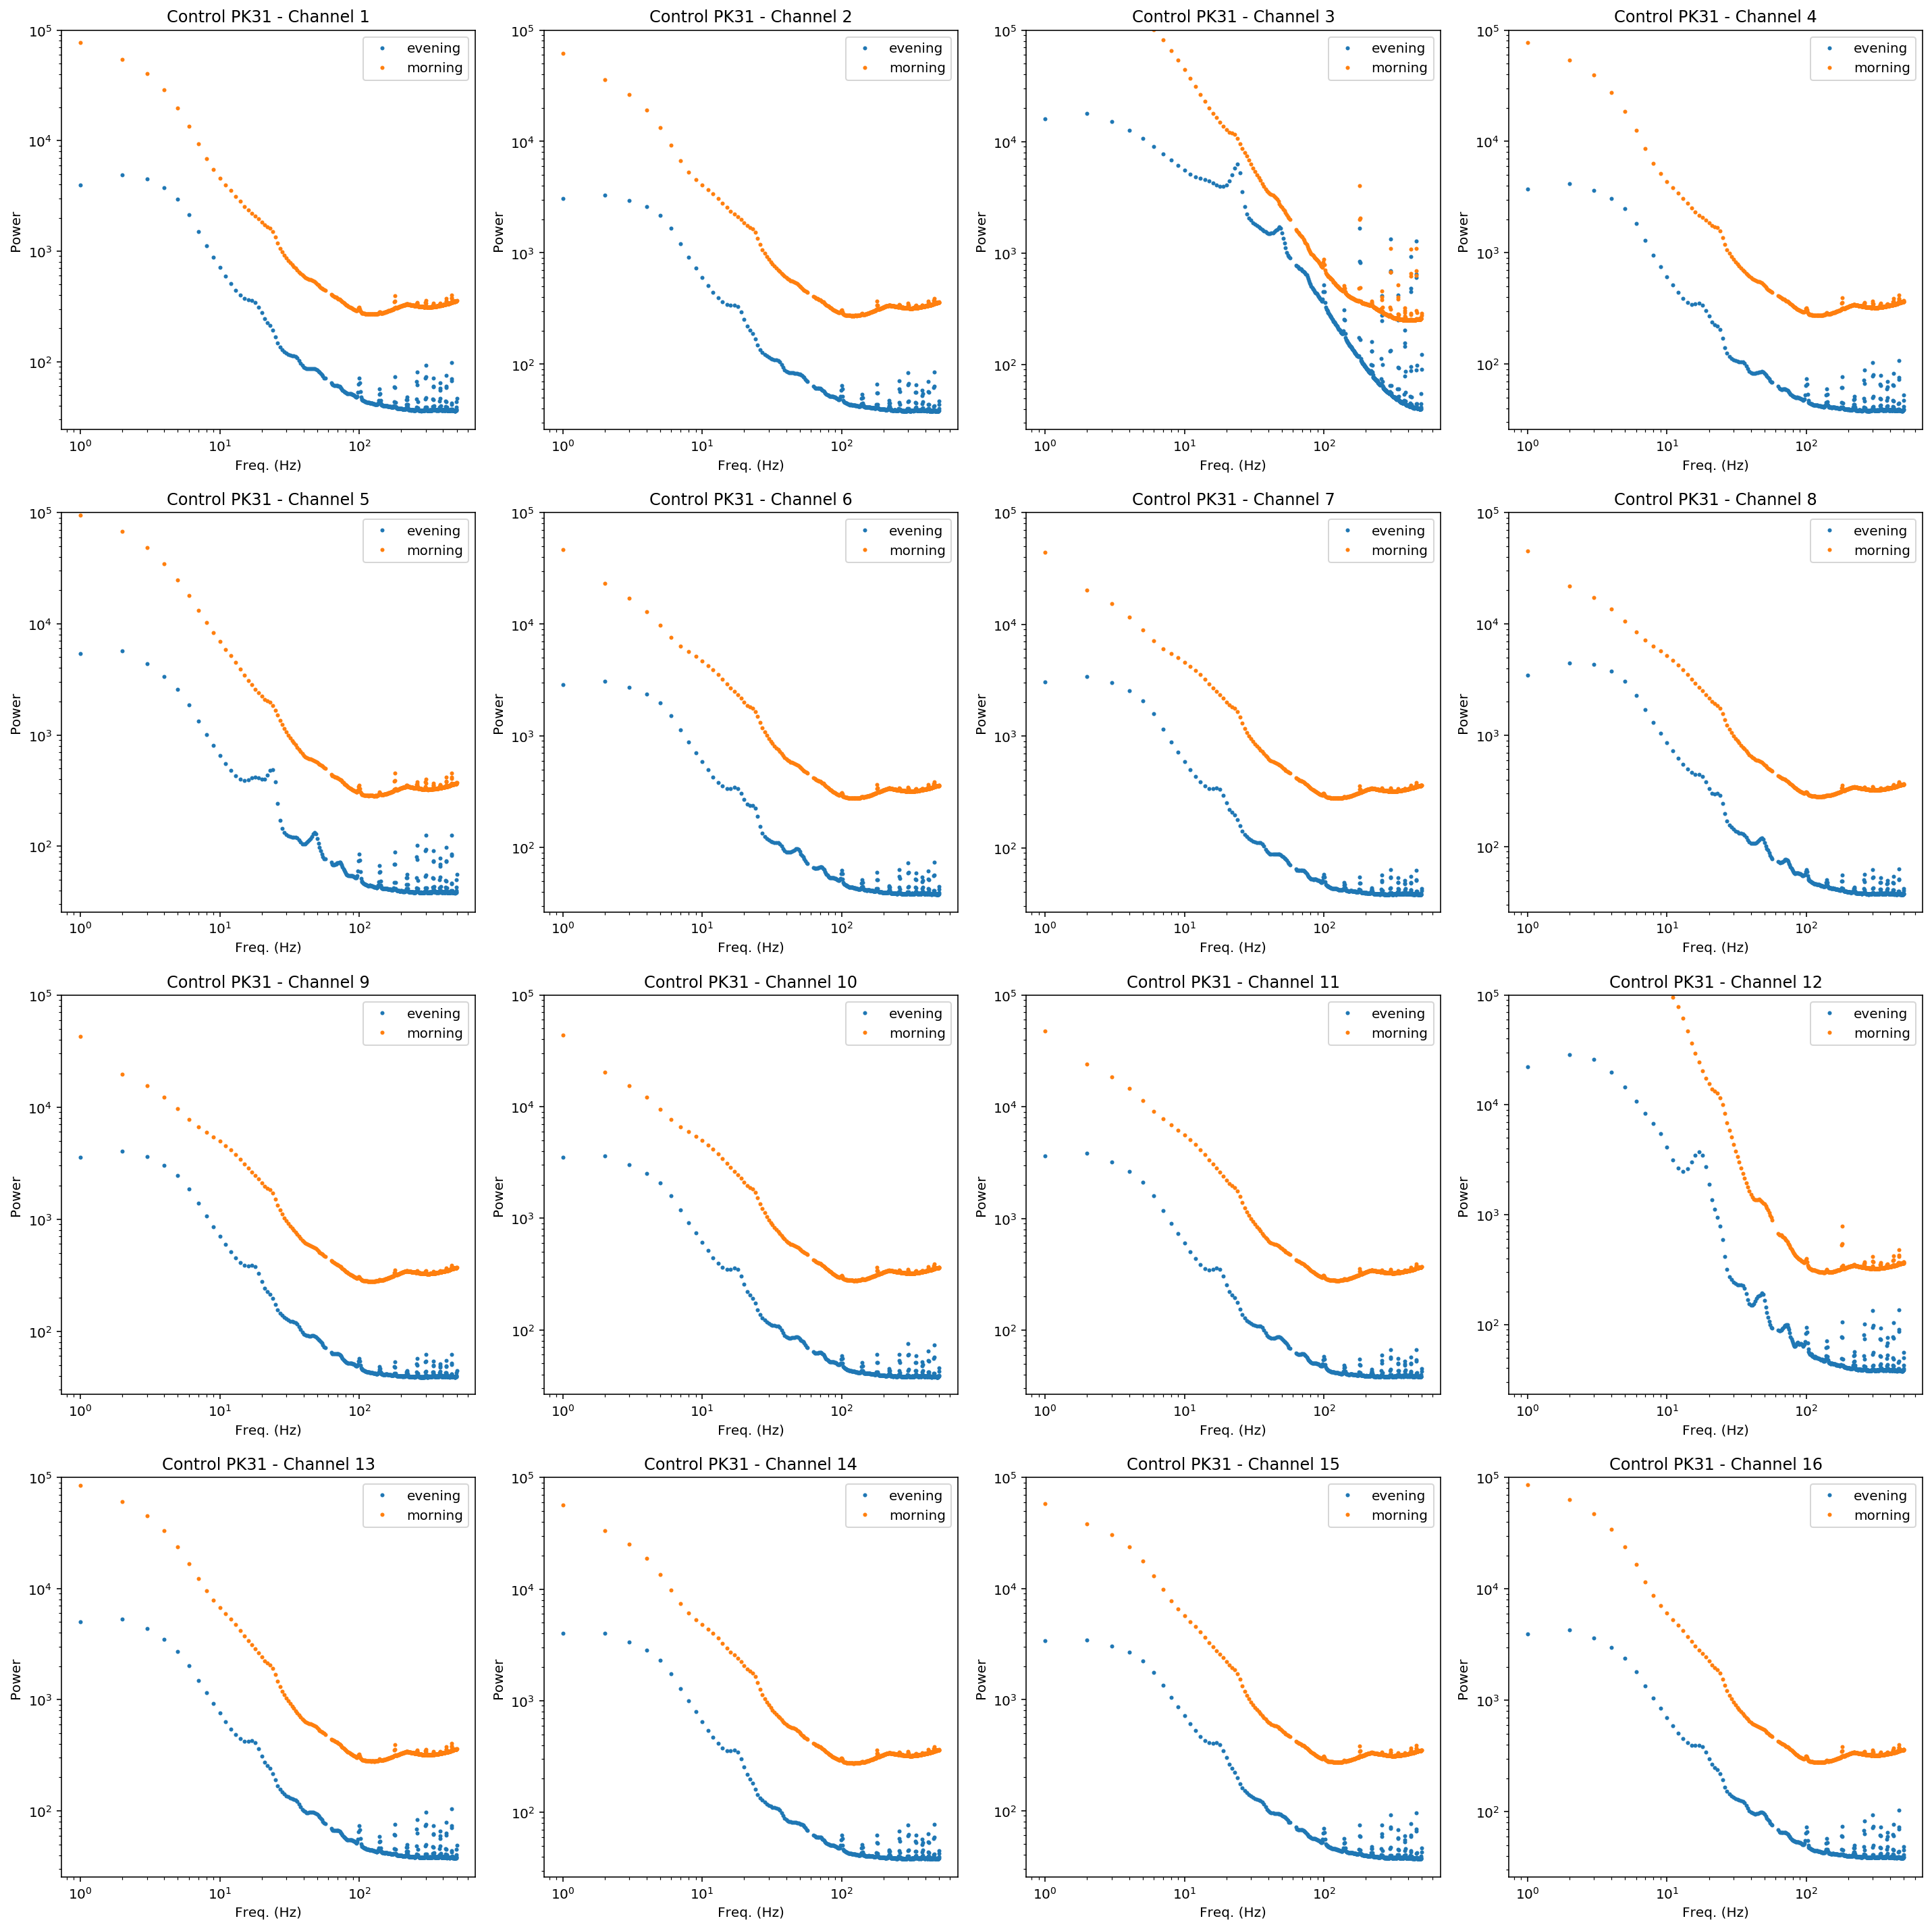

In [193]:
plot_channels(df_bird2_test, bird2)

#### !!! Manually define channels with broken electrodes to be removed from bird 2 data OR define single channel to keep

Note: Based on wavelet transform data during singing, we decided to keep channels 2, 4, 6, 7, 8, 9, 10, 11, 13, 14, 15 for PK31.

In [194]:
# If averaging over multiple channels:
# Define channels with broken electrodes to remove (leave array empty if none)
bad_channels_b2 = [1, 3, 5, 12, 16]

# If only keeping one single channel (ignored if channels_used == "multi"):
single_channel2 = 10

In [195]:
if channels_used == "single":
    bad_channels_b2 = df_bird2['channel'].unique()[df_bird2['channel'].unique() != single_channel2]

In [196]:
for bad_channel in np.concatenate((bad_channels_b2, outside_HVC)):
    # Exclude bad channels and channels located outside HVC from test df (power values averaged across all days)
    df_bird2_test = df_bird2_test[df_bird2_test.channel != bad_channel]
    
    # Excluse bad channels and channels located outside HVC from original df
    df_bird2 = df_bird2[df_bird2.channel != bad_channel]
    
# for bad_channel in bad_channels_b2:
#     # Exclude bad channels from test df (power values averaged across all days)
#     df_bird2_test = df_bird2_test[df_bird2_test.channel != bad_channel]
    
#     # Excluse bad channels from original df
#     df_bird2 = df_bird2[df_bird2.channel != bad_channel]

In [197]:
# Show new channel list
df_bird2["channel"].unique()

array([ 2,  4,  6,  8, 10, 14])

___

# Compare Power/Freq graph between animals by averaging across all channels

Average power values across all channels (excluding bad channels):

In [198]:
# Bird 1
df_bird1_test_2 = df_bird1_test.groupby(["daytime", "freq"])[["power"]].apply(np.mean)
df_bird1_test_2 = df_bird1_test_2.reset_index()

# Bird 2
df_bird2_test_2 = df_bird2_test.groupby(["daytime", "freq"])[["power"]].apply(np.mean)
df_bird2_test_2 = df_bird2_test_2.reset_index()

/var/folders/gd/8j_w3s656d1gkl7jfdnptqpc0000gq/T/ipykernel_11355/2452910435.py:24: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


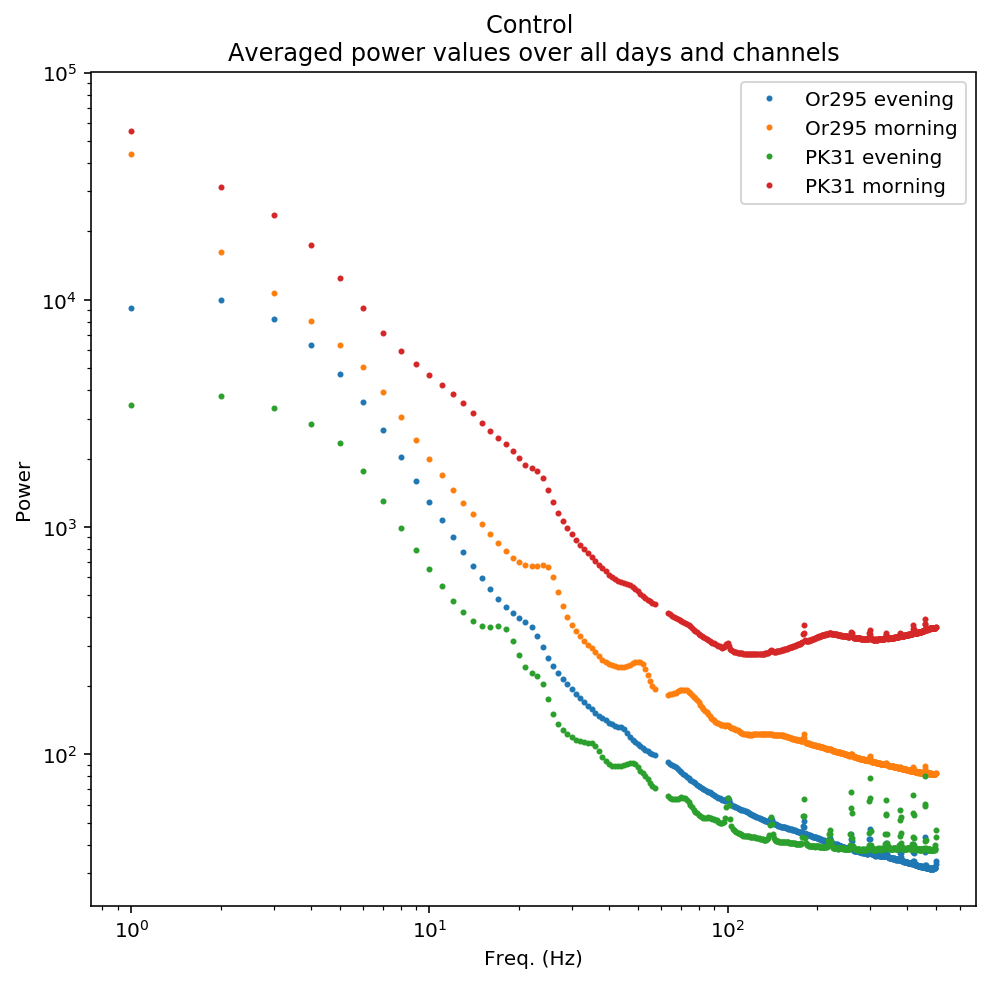

In [199]:
fig, ax = plt.subplots(figsize=(7, 7))

for name, group in df_bird1_test_2.groupby("daytime"):
    ax.plot(group["freq"], group["power"], label=f"{bird1} {name}", marker='o', markersize=2, linestyle='', linewidth=2)
    
for name, group in df_bird2_test_2.groupby("daytime"):
    ax.plot(group["freq"], group["power"], label=f"{bird2} {name}", marker='o', markersize=2, linestyle='', linewidth=2)

ax.set(**{
    "xlabel": "Freq. (Hz)",
    "ylabel": "Power",
    "title": "{} \nAveraged power values over all days and channels".format(condition)
})

# Change axes to log scale
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(top=100000)

# Add legend
ax.legend()
    
plt.tight_layout()    
fig.show()

___

# Add NaNs values to all days that do not have a recording for each bird

Supplement NaNs values to all days that do not have a recording for each bird. After this, each dataframe includes all days (0-143). (143 is last day recorded for any bird.)

In [200]:
# def add_NA(df_bird):
#     """
#     Add NA values to data frame for all days between 0 and 143 that are missing.
#     This function works for the data frames that still include power values for all frequencies.
#     """
#     freq_range_clean = df_bird["freq"].unique()

#     for daytime in df_bird["daytime"].unique():
#         # Get one daytime
#         df = df_bird[df_bird["daytime"] == daytime]
#         df_temp = pd.DataFrame()
        
#         # Find all days that are missing from data frame 
#         days_missing = np.array(list(set(df["day"].unique()) ^ set(np.arange(144))))

#         if len(days_missing) > 0:
#             # Add them to new dataframe, repeating each day as many times as there are frequencies
#             df_temp["day"] = np.repeat(days_missing, len(freq_range_clean))
#             # Add frequency values for each unique day
#             df_temp["freq"] = np.concatenate([freq_range_clean,] * len(days_missing))
#             # Add daytime
#             df_temp["daytime"] = daytime
#             # Add NA to power values
#             df_temp["power"] = np.nan

#             df_bird = pd.concat([df_bird, df_temp])
        
#     return df_bird

In [201]:
# # Show days before supplementing NaNs
# np.sort(df_bird1["day"].unique())

In [202]:
# df_bird1 = add_NA(df_bird1)
# df_bird2 = add_NA(df_bird2)

In [203]:
# # Show days after supplementing NaNs
# np.sort(df_bird1["day"].unique())

___

# !!! Drop power values for days 38, 41, 42 and 44 for Or295 and day 86 for PK31
Defined as outliers due to very high power across all frequencies or STD 100x higher than on other days.

In [204]:
# # Replace power values by NaN
# df_bird1['power'] = np.where(df_bird1['day'] == 27, np.nan, df_bird1['power'])
# df_bird1['power'] = np.where(df_bird1['day'] == 38, np.nan, df_bird1['power'])
# df_bird1['power'] = np.where(df_bird1['day'] == 41, np.nan, df_bird1['power'])
# df_bird1['power'] = np.where(df_bird1['day'] == 42, np.nan, df_bird1['power'])
# df_bird1['power'] = np.where(df_bird1['day'] == 44, np.nan, df_bird1['power'])

# df_bird2['power'] = np.where(df_bird2['day'] == 86, np.nan, df_bird2['power'])

In [205]:
# Drop row for this day entirely
df_bird1 = df_bird1[df_bird1.day != 27]
df_bird1 = df_bird1[df_bird1.day != 38]
df_bird1 = df_bird1[df_bird1.day != 41]
df_bird1 = df_bird1[df_bird1.day != 42]
df_bird1 = df_bird1[df_bird1.day != 44]

df_bird2 = df_bird2[df_bird2.day != 86]

___

# Save clean data as csv

Sort, concatenate and save data frames as csv:

In [206]:
# Sort data frames by day, daytime and freq
df_bird1 = df_bird1.sort_values(["daytime", "day", "channel", "hour", "freq"])
df_bird2 = df_bird2.sort_values(["daytime", "day", "channel", "hour", "freq"])

# Add condition and animal ID
df_bird1["condition"] = condition
df_bird1["animal_ID"] = bird1
df_bird2["condition"] = condition
df_bird2["animal_ID"] = bird2

# Concatenate data frames from replicates
df_concat = pd.concat([df_bird1, df_bird2]) 

# Save as csv
if channels_used == "multi":
    df_concat.to_csv(f"{condition}_clean_multi-channel.csv", index=False)
    
if channels_used == "single":
    df_concat.to_csv(f"{condition}_clean_single-channel.csv", index=False)

Split csv into smaller files for saving on Github (since it is > 100 MB):

In [216]:
# Split data into files of 75 MB
!split -b 75m control_clean_multi-channel.csv control_clean_multi-channel_
# Delete original csv file
!rm control_clean_multi-channel.csv
# !rm control_clean_single-channel.csv

Move split clean data files to designated folder:

In [ ]:
!mv control_clean_multi-channel_aa clean_data/control_clean_multi-channel_aa
!mv control_clean_multi-channel_ab clean_data/control_clean_multi-channel_ab
!mv control_clean_multi-channel_ac clean_data/control_clean_multi-channel_ac